In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean, cityblock

from PIL import Image
from rdm import *

In [2]:
f_cond=[
    ('F01','Joy','unshuffled'),
    ('F01','Joy','shuffled'),
    ('F03','Joy','unshuffled'),
    ('F03','Joy','shuffled'),
    ('F02','Sadness','unshuffled'),
    ('F02','Sadness','shuffled'),
    ('F04','Sadness','unshuffled'),
    ('F04','Sadness','shuffled'),
    ('F06','MouthOpening','unshuffled'),
    ('F06','MouthOpening','shuffled'),
    ('F07','MouthOpening','unshuffled'),
    ('F07','MouthOpening','shuffled')
]
f_label=[]
for (actor,movement,status) in f_cond:
    f_label.append('{} {} {}'.format(actor,movement,status))

In [3]:
out_base_path='/home/bonaiuto/infant_face_eeg/derivatives/9m'
stim_path='/home/common/bonaiuto/infant_face_eeg/stimuli/9month'
n_pixels=1244160
n_flow=576
n_gabor=414720
n_frames=121


def generate_pixel_dynamic_rdm(f_cond):
    dynamic_image_vectors = np.zeros((len(f_cond), n_frames, n_pixels))

    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        cond_path = os.path.join(stim_path, 'frames', f'{actor}-{movement}')
        if status == 'shuffled':            
            cond_path = os.path.join(cond_path, status)
        elif movement=='MouthOpening':
            cond_path = os.path.join(cond_path, 'short')
        frame_fnames = sorted(glob.glob(os.path.join(cond_path, 'frame-*.png')))
        frame_fnames=frame_fnames[:n_frames]
        
        # Use Joblib to parallelize frame processing
        results = Parallel(n_jobs=-1)(delayed(process_frame_pixel)(frame_fname, n_pixels) for frame_fname in frame_fnames)

        dynamic_image_vectors[f_idx,:,:]=np.array(results)

    rdm = Parallel(n_jobs=-1)(delayed(compute_frame_pixel_rdm)(dynamic_image_vectors[:, j, :]) for j in range(n_frames))
    return np.array(rdm)


def generate_contrast_dynamic_rdm(f_cond):
    dynamic_image_contrasts = np.zeros((len(f_cond), n_frames))

    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        cond_path = os.path.join(stim_path, 'frames', f'{actor}-{movement}')
        if status == 'shuffled':            
            cond_path = os.path.join(cond_path, status)
        elif movement=='MouthOpening':
            cond_path = os.path.join(cond_path, 'short')
        frame_fnames = sorted(glob.glob(os.path.join(cond_path, 'frame-*.png')))
        frame_fnames=frame_fnames[:n_frames]
        
        # Use Joblib to parallelize frame processing
        results = Parallel(n_jobs=-1)(delayed(process_frame_contrast)(frame_fname) for frame_fname in frame_fnames)

        dynamic_image_contrasts[f_idx,:]=np.array(results)

    rdm = Parallel(n_jobs=-1)(delayed(compute_frame_contrast_rdm)(dynamic_image_contrasts[:, j]) for j in range(n_frames))
    return np.array(rdm)


def generate_total_flow_dynamic_rdm(f_cond):
    dynamic_image_total_flow = np.zeros((len(f_cond), n_frames))

    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        cond_path = os.path.join(stim_path, 'frames', f'{actor}-{movement}')
        if status == 'shuffled':            
            cond_path = os.path.join(cond_path, status)
        elif movement=='MouthOpening':
            cond_path = os.path.join(cond_path, 'short')
        frame_fnames = sorted(glob.glob(os.path.join(cond_path, 'frame-*.png')))
        frame_fnames=frame_fnames[:n_frames]
        
        # Use Joblib to parallelize frame processing
        results = Parallel(n_jobs=-1)(delayed(process_frame_total_flow)(frame_fname, None if i == 0 else skimage.io.imread(frame_fnames[i - 1], as_gray=True)) for i, frame_fname in enumerate(frame_fnames))

        dynamic_image_total_flow[f_idx,:]=np.array(results)

    rdm = Parallel(n_jobs=-1)(delayed(compute_frame_total_flow_rdm)(dynamic_image_total_flow[:, j]) for j in range(n_frames))
    return np.array(rdm)


def generate_flow_dynamic_rdm(f_cond):
    dynamic_image_flow = np.zeros((len(f_cond), n_frames, n_flow))

    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        cond_path = os.path.join(stim_path, 'frames', f'{actor}-{movement}')
        if status == 'shuffled':            
            cond_path = os.path.join(cond_path, status)
        elif movement=='MouthOpening':
            cond_path = os.path.join(cond_path, 'short')
        frame_fnames = sorted(glob.glob(os.path.join(cond_path, 'frame-*.png')))
        frame_fnames=frame_fnames[:n_frames]
        
        # Use Joblib to parallelize frame processing
        results = Parallel(n_jobs=-1)(delayed(process_frame_flow)(frame_fname, None if i == 0 else skimage.io.imread(frame_fnames[i - 1], as_gray=True), n_flow) for i, frame_fname in enumerate(frame_fnames))

        dynamic_image_flow[f_idx,:,:]=np.array(results)

    rdm = Parallel(n_jobs=-1)(delayed(compute_frame_flow_rdm)(dynamic_image_flow[:, j, :]) for j in range(n_frames))
    return np.array(rdm)


def generate_gabor_dynamic_rdm(f_cond):
    orientations = 6  # Different orientations
    scales = 6
    #dynamic_gabor_vectors = np.zeros((len(f_cond), n_frames, orientations*4*n_gabor))

    all_frames={}
    # Loop over conditions
    for actor, movement, status in f_cond:
        print(f'{actor} {movement} {status}')
        cond_path = os.path.join(stim_path, 'frames', f'{actor}-{movement}')
        if status == 'shuffled':            
            cond_path = os.path.join(cond_path, status)
        elif movement=='MouthOpening':
            cond_path = os.path.join(cond_path, 'short')
        frame_fnames = sorted(glob.glob(os.path.join(cond_path, 'frame-*.png')))
        frame_fnames=frame_fnames[:n_frames]
        all_frames[(actor,movement,status)]=frame_fnames
        
    rdm=np.zeros((n_frames,len(f_cond),len(f_cond)))
    for f_idx in range(n_frames):     
        print(f'{f_idx}/{n_frames}')
        results = Parallel(n_jobs=-1)(delayed(process_frame_gabor)(all_frames[(actor,movement,status)][f_idx], orientations, scales, n_gabor) for (actor,movement,status) in f_cond)
        gabor_vectors=np.array(results)
        
        gabor_corr, _ = spearmanr(gabor_vectors.T)
        gabor_corr = 0.5 * (gabor_corr + gabor_corr.T)  # Making the matrix symmetric
        frame_rdm = 1-gabor_corr
        np.fill_diagonal(frame_rdm, 0) 
        rdm[f_idx,:,:]=frame_rdm
    return rdm

def generate_landmark_dynamic_rdm(f_cond):
    dynamic_landmark_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')
        
        df=pd.read_csv(fname)
        
        # Selecting the X_0 to X_67, Y_0 to Y_67, and Z_0 to Z_67 columns and converting them to a numpy array
        selected_columns = ['X_{}'.format(i) for i in range(16,68)] + \
                        ['Y_{}'.format(i) for i in range(16,68)] + \
                        ['Z_{}'.format(i) for i in range(16,68)]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
        
        # Get last row
        landmark_vectors=[]
        for row_idx in range(n_frames):
            vector = values_array[row_idx,:]
            landmark_vectors.append(vector)
        dynamic_landmark_vectors.append(landmark_vectors)
            
    dynamic_landmark_vectors=np.array(dynamic_landmark_vectors)
    
    # Calculating the RDM matrix
    rdm=[]
    
    for t in range(n_frames):
        landmark_rdm = np.zeros((len(f_cond), len(f_cond)))
        
        # Compute the Euclidean distances and populate the distance matrix
        for i in range(len(f_cond)):
            for j in range(i+1,len(f_cond)):
                distances = [
                    euclidean(dynamic_landmark_vectors[i][t][k*3:k*3+3], dynamic_landmark_vectors[j][t][k*3:k*3+3]) for k in range(int(dynamic_landmark_vectors.shape[-1]/3))
                ]
                # Take the average of the distances for X, Y, and Z coordinates
                avg_distance = np.mean(distances)
                landmark_rdm[i, j] = avg_distance
                landmark_rdm[j, i] = avg_distance
        rdm.append(landmark_rdm)
    rdm=np.array(rdm)
    return rdm


def generate_au_r_dynamic_rdm(f_cond):
    dynamic_au_r_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')

        df=pd.read_csv(fname)
        
        selected_columns = [
         'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 
         'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'
        ]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
    
        au_r_vectors=[]
        for row_idx in range(n_frames):
            # Since the DataFrame has one row, select the first row to get a vector
            vector = values_array[row_idx,:]
            au_r_vectors.append(vector)
        dynamic_au_r_vectors.append(au_r_vectors)                
    
    dynamic_au_r_vectors=np.array(dynamic_au_r_vectors)

    dynamic_au_r_vectors+=.001*np.random.randn(dynamic_au_r_vectors.shape[0], dynamic_au_r_vectors.shape[1], dynamic_au_r_vectors.shape[2])
    rdm=[]
    for t in range(n_frames):
        au_r_corr, _ = spearmanr(dynamic_au_r_vectors[:,t,:].T)
        au_r_corr = 0.5 * (au_r_corr + au_r_corr.T)  # Making the matrix symmetric
        
        # Calculating the RDM matrix
        au_r_rdm = 1-au_r_corr
        np.fill_diagonal(au_r_rdm, 0)  # Setting the diagonal to zero
        rdm.append(au_r_rdm)
    rdm=np.array(rdm)
    return rdm

def generate_au_c_dynamic_rdm(f_cond):
    dynamic_au_c_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')
    
        df=pd.read_csv(fname)
        
        selected_columns = [
         'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 
         'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c'
        ]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
    
        au_c_vectors=[]
        for row_idx in range(n_frames):
            # Since the DataFrame has one row, select the first row to get a vector
            vector = values_array[row_idx,:]
            au_c_vectors.append(vector)
        dynamic_au_c_vectors.append(au_c_vectors)
    
    dynamic_au_c_vectors=np.array(dynamic_au_c_vectors)

    rdm=[]
    for t in range(n_frames):
        # Calculate the Manhattan distances between binary vectors
        au_c_rdm = np.zeros((len(f_cond), len(f_cond)))
        
        for i in range(len(f_cond)):
            for j in range(i + 1, len(f_cond)):
                distance = cityblock(dynamic_au_c_vectors[i,t,:], dynamic_au_c_vectors[j,t,:])
                au_c_rdm[i, j] = distance
                au_c_rdm[j, i] = distance  # RDM matrix is symmetric
        
        # Set the diagonal to zero
        np.fill_diagonal(au_c_rdm, 0)
        rdm.append(au_c_rdm)
    
    rdm=np.array(rdm)
    return rdm

In [4]:
actor_rdm=generate_actor_dynamic_rdm(f_cond, n_frames)

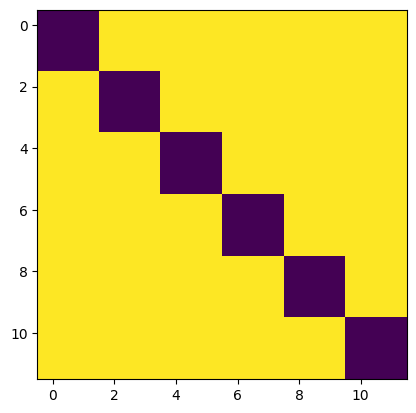

In [5]:
plt.imshow(actor_rdm[0,:,:])

In [6]:
movement_type_rdm=generate_movement_type_dynamic_rdm(f_cond, n_frames)

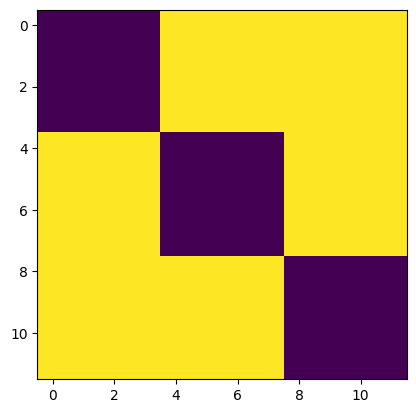

In [7]:
plt.imshow(movement_type_rdm[0,:,:])

In [8]:
shuffled_rdm=generate_shuffled_dynamic_rdm(f_cond, n_frames)

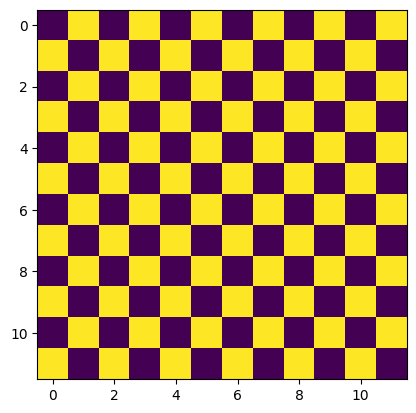

In [9]:
plt.imshow(shuffled_rdm[0,:,:])

In [10]:
pixel_dynamic_rdm=generate_pixel_dynamic_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


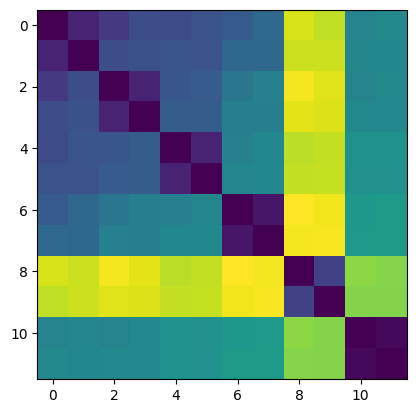

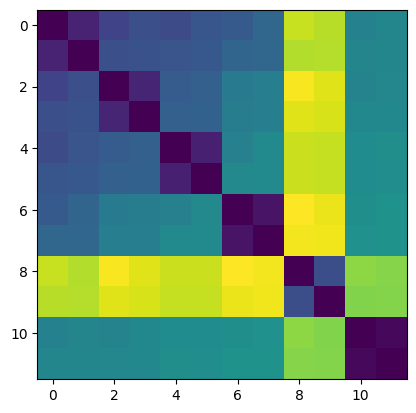

In [11]:
plt.figure()
plt.imshow(pixel_dynamic_rdm[0,:,:])
plt.figure()
plt.imshow(pixel_dynamic_rdm[-1,:,:])

In [12]:
contrast_dynamic_rdm=generate_contrast_dynamic_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


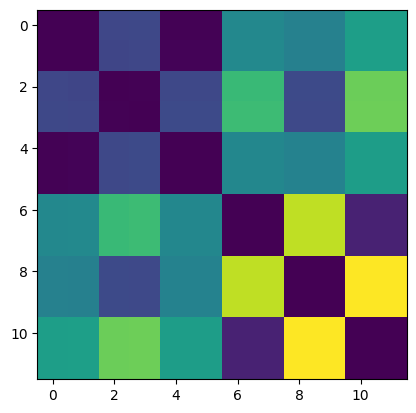

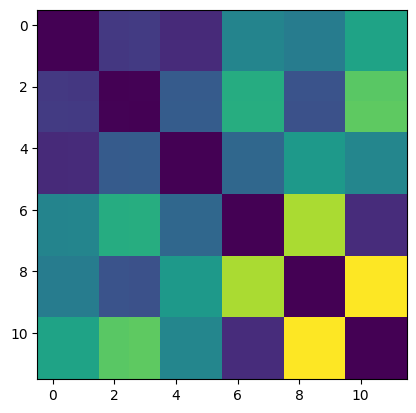

In [13]:
plt.figure()
plt.imshow(contrast_dynamic_rdm[0,:,:])
plt.figure()
plt.imshow(contrast_dynamic_rdm[-1,:,:])

In [14]:
total_flow_dynamic_rdm=generate_total_flow_dynamic_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


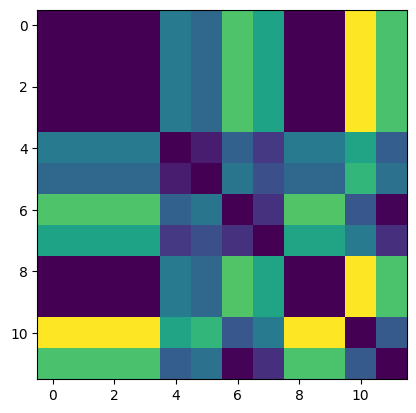

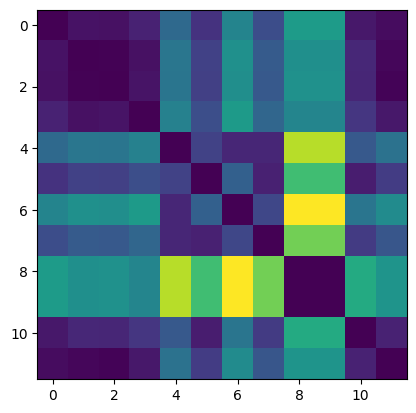

In [15]:
plt.figure()
plt.imshow(total_flow_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(total_flow_dynamic_rdm[-1,:,:])

In [16]:
flow_dynamic_rdm=generate_flow_dynamic_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


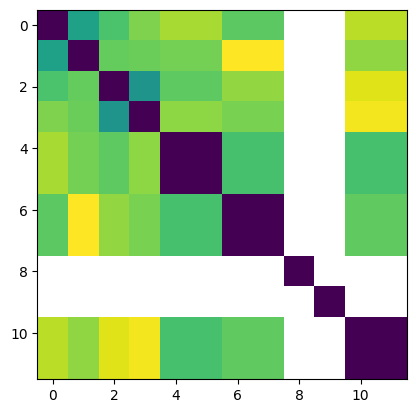

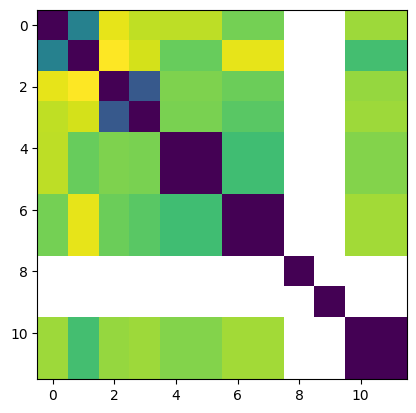

In [17]:
plt.figure()
plt.imshow(flow_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(flow_dynamic_rdm[-1,:,:])

In [18]:
gabor_dynamic_rdm=generate_gabor_dynamic_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled
0/121
1/121
2/121
3/121
4/121
5/121
6/121
7/121
8/121
9/121
10/121
11/121
12/121
13/121
14/121
15/121
16/121
17/121
18/121
19/121
20/121
21/121
22/121
23/121
24/121
25/121
26/121
27/121
28/121
29/121
30/121
31/121
32/121
33/121
34/121
35/121
36/121
37/121
38/121
39/121
40/121
41/121
42/121
43/121
44/121
45/121
46/121
47/121
48/121
49/121
50/121
51/121
52/121
53/121
54/121
55/121
56/121
57/121
58/121
59/121
60/121
61/121
62/121
63/121
64/121
65/121
66/121
67/121
68/121
69/121
70/121
71/121
72/121
73/121
74/121
75/121
76/121
77/121
78/121
79/121
80/121
81/121
82/121
83/121
84/121
85/121
86/121
87/121
88/121
89/121
90/121
91/121
92/121
93/121
94/121
95/121
96/121
97/121
98/121
99/121
100/121
101/121
102/121
103/121
104/121
10

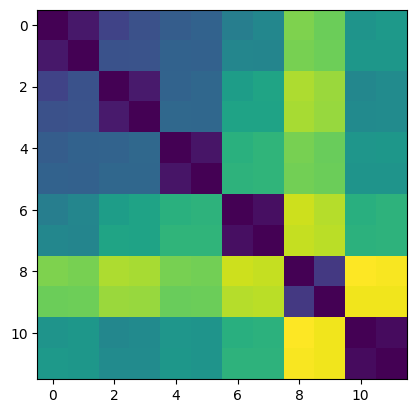

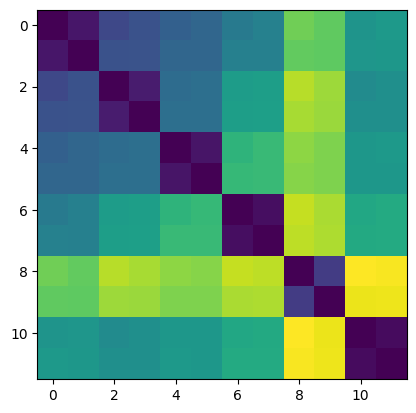

In [19]:
plt.figure()
plt.imshow(gabor_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(gabor_dynamic_rdm[-1,:,:])

In [20]:
landmark_dynamic_rdm=generate_landmark_dynamic_rdm(f_cond)

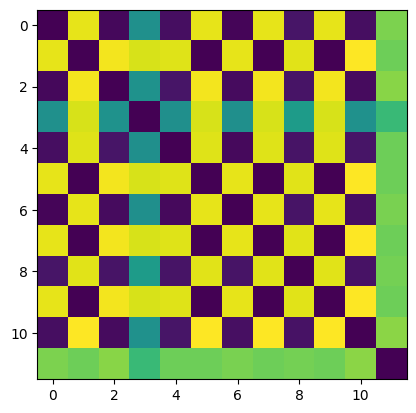

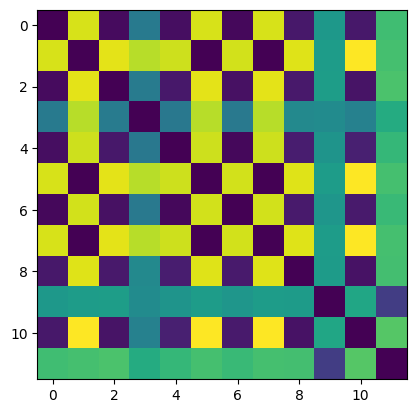

In [21]:
plt.figure()
plt.imshow(landmark_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(landmark_dynamic_rdm[-1,:,:])

In [22]:
au_r_dynamic_rdm=generate_au_r_dynamic_rdm(f_cond)

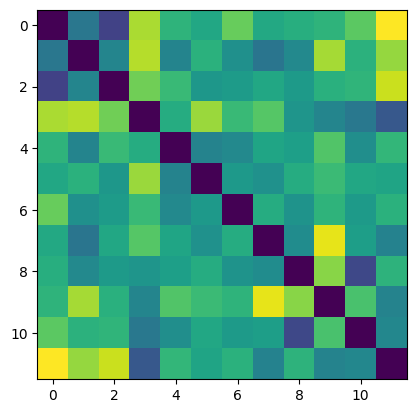

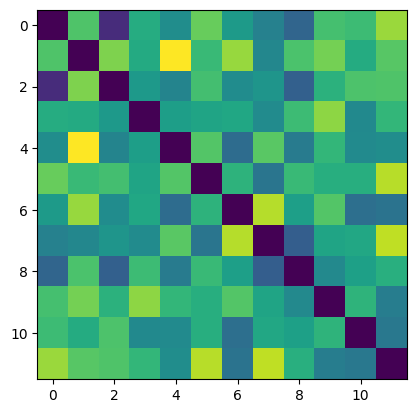

In [23]:
plt.figure()
plt.imshow(au_r_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(au_r_dynamic_rdm[-1,:,:])

In [24]:
au_c_dynamic_rdm=generate_au_c_dynamic_rdm(f_cond)

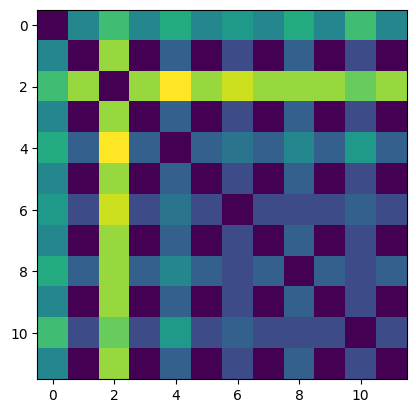

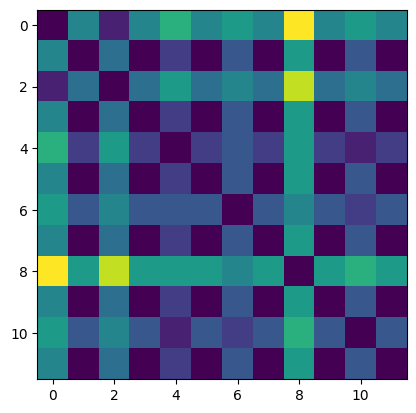

In [25]:
plt.figure()
plt.imshow(au_c_dynamic_rdm[10,:,:])
plt.figure()
plt.imshow(au_c_dynamic_rdm[-1,:,:])

In [26]:
model_rdms={
    'actor': actor_rdm,
    'movement_type': movement_type_rdm,
    'shuffled': shuffled_rdm,
    'pixel': pixel_dynamic_rdm,
    'contrast': contrast_dynamic_rdm,
    'total_flow': total_flow_dynamic_rdm,
    'flow': flow_dynamic_rdm,
    'gabor': gabor_dynamic_rdm,
    'landmark': landmark_dynamic_rdm,
    'au_r': au_r_dynamic_rdm,
    'au_c': au_c_dynamic_rdm
}
np.savez(
    os.path.join(out_base_path, 'model_dynamic_rdms.npz'),
    model_rdms=model_rdms
)

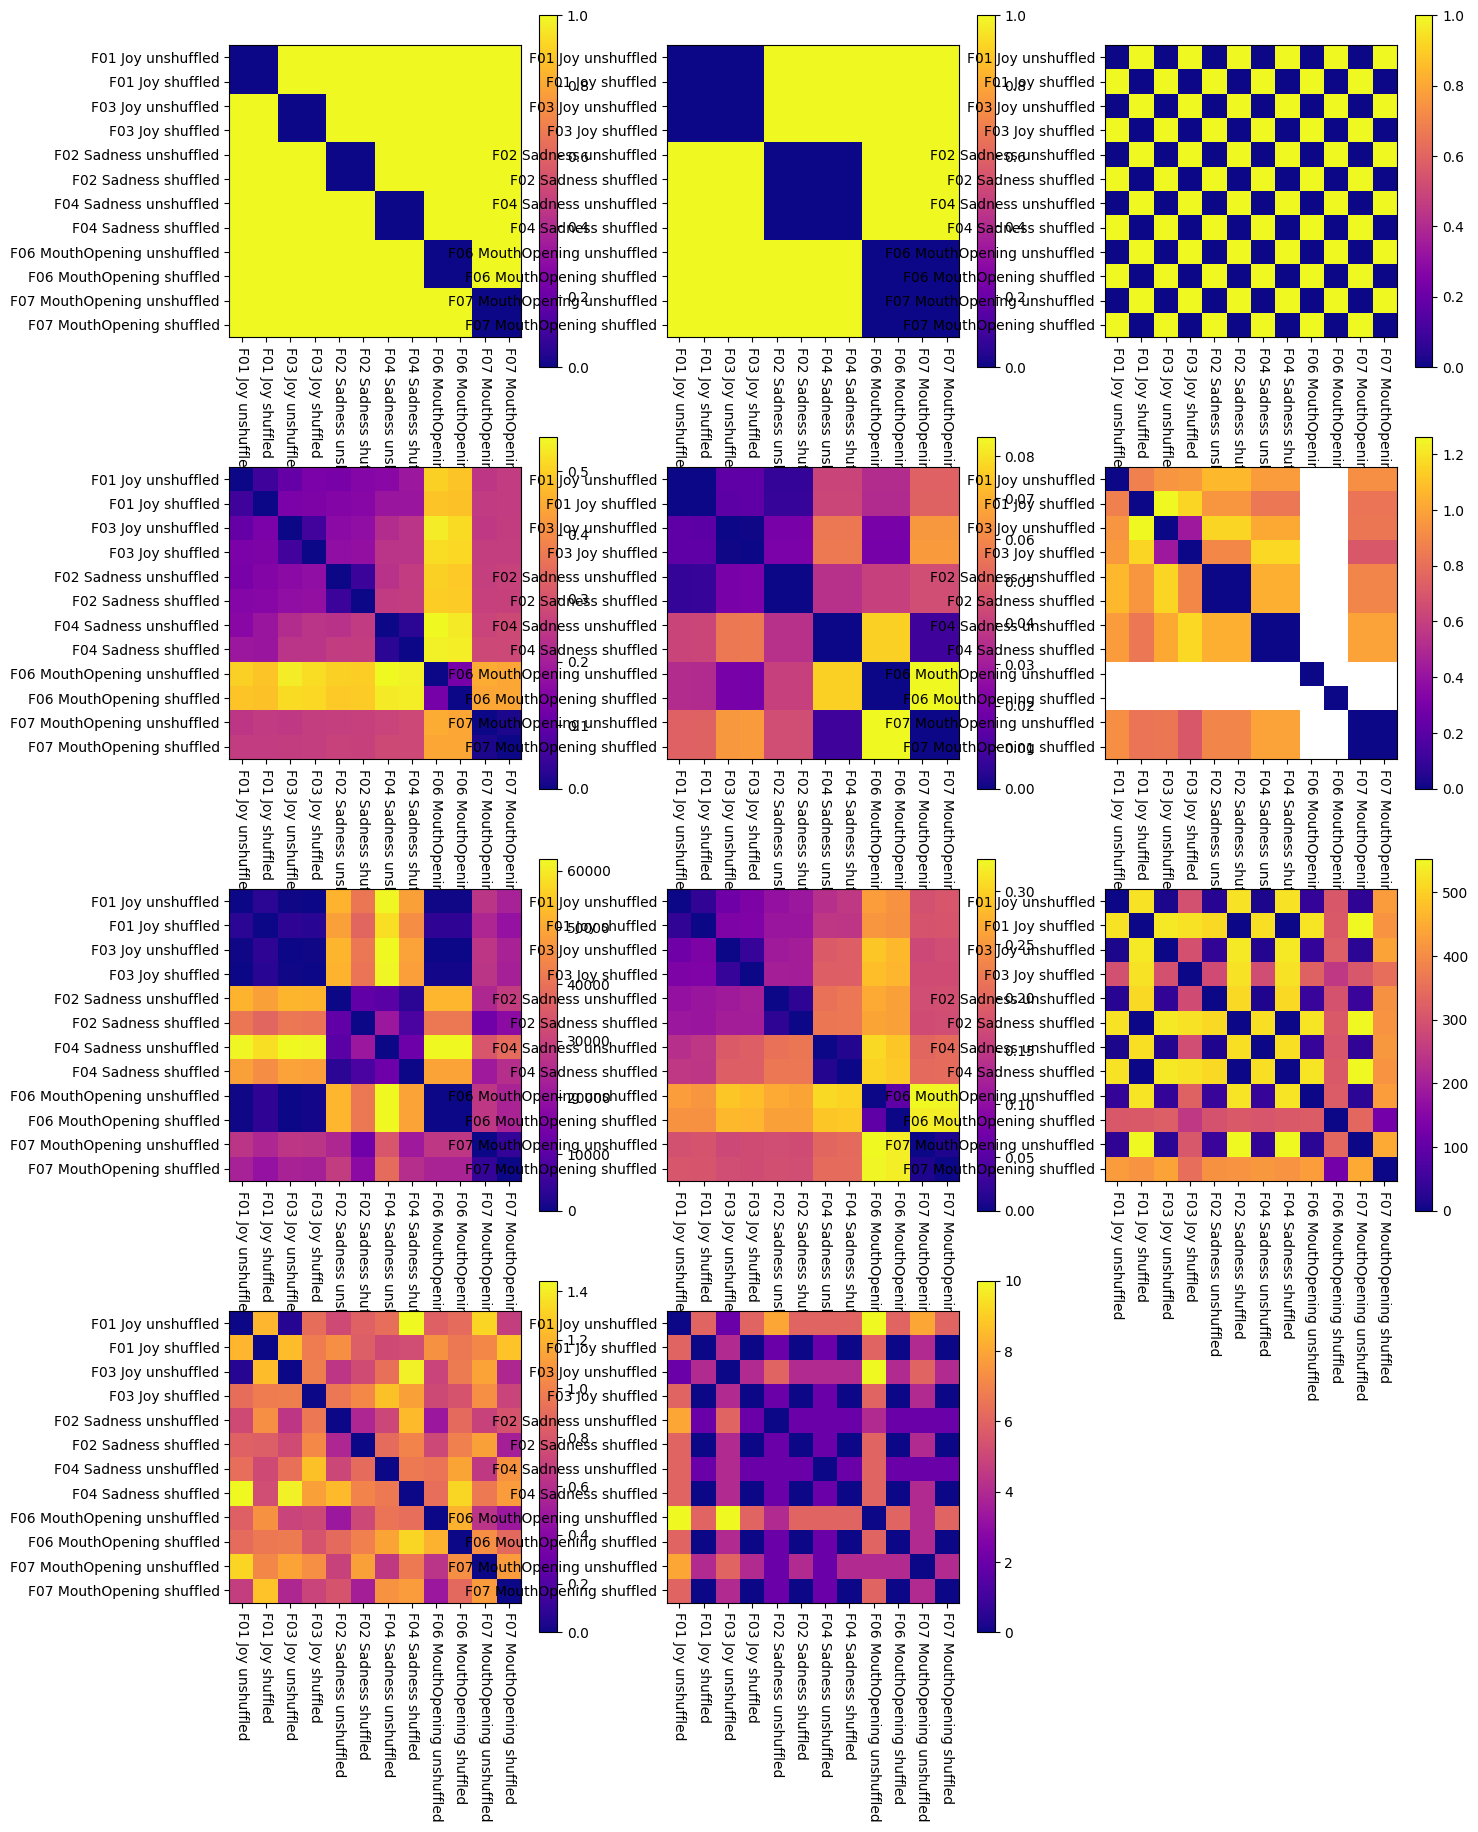

/home/bonaiuto/miniconda3/envs/face_blaster/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bonaiuto/miniconda3/envs/face_blaster/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bonaiuto/miniconda3/envs/face_blaster/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/bonaiuto/miniconda3/envs/face_blaster/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bonaiuto/miniconda3/envs/face_blaster/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bonaiuto/miniconda3/env

In [27]:
plt.figure(figsize=(16,21))

ax=plt.subplot(4,3,1)
im=ax.imshow(actor_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,2)
im=ax.imshow(movement_type_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,3)
im=ax.imshow(shuffled_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,4)
im=ax.imshow(pixel_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,5)
im=ax.imshow(contrast_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,6)
im=ax.imshow(flow_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,7)
im=ax.imshow(total_flow_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,8)
im=ax.imshow(gabor_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,9)
im=ax.imshow(landmark_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,10)
im=ax.imshow(au_r_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,11)
im=ax.imshow(au_c_dynamic_rdm[50,:,:], cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)
# plt.savefig('../output/RMDs.svg')